In [5]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import math
import time
import matplotlib.gridspec as gridspec

from astropy.io import ascii
from itertools import cycle
from itertools import permutations
from scipy.stats import skew

%matplotlib inline

In [23]:
def getLossFromLogfile(filename):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    lastEpoch = content[-5].split("|")
    lastEpochCost = float(lastEpoch[2].split(" ")[2])
    return lastEpochCost

In [24]:
def getLossSeriesFromLogfile(filename,nEpochs=500):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    
    losses = np.zeros((nEpochs))
    for j in range(14,14+nEpochs):
        temp = content[j].split("|")
        losses[j-14] = float(temp[2].split(" ")[2])

    return losses

In [68]:
def randomStablePlanet(testSetSystems, testSetResults, trainingSetResults, trainingSetData, nSamples):
    """
    Predict properties of a planet randomly. (Do not allow orbit crossings, assuming circularity.)
    
    """
    randomPredictions = np.zeros((len(testSetResults), nSamples, np.shape(trainingSetData)[1]))
    
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity
        
        m = len(thisSystem)
        
        # planet by planet
        for j in range(0,m):
            if j == 0:
                Pmin = np.min(trainingSetData[:,1])
            else:
                Pmin = thisSystem[j-1][1]
                
            if (j == (m-1)):
                Pmax = np.max(trainingSetData[:,1])
            else:
                Pmax = thisSystem[j+1][1]
            
            #draw random planets from the training set that have acceptable periods
            samplePlanets = np.zeros((nSamples,np.shape(trainingSetData)[1]))
            
            allowedPMask = (trainingSetData[:,1] > Pmin) & (trainingSetData[:,1] < Pmax)
            allowedPIdxs = np.arange(len(trainingSetData))[allowedPMask]
            #print(len(allowedPIdxs))
            if len(allowedPIdxs) == 0:
                break
            
            if nSamples > len(allowedPIdxs):
                print("{0}: not enough stable planets".format(j))
                break
            
            samplePlanetIdxs = np.random.choice(allowedPIdxs,size=nSamples)
            samplePlanets = trainingSetData[samplePlanetIdxs]
            randomPredictions[planetCounter] = samplePlanets
            planetCounter+=1
                
    return randomPredictions
    

# Loop over different random seeds

In [147]:
KOIs = ascii.read("../../../KOIs_chen2018_goodSystems.csv")

obs_features = np.vstack((np.log10(np.array(KOIs['koi_ror'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T
mod_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_sma'])).T,np.log10(np.array(KOIs['koi_insol'])).T,np.log10(np.array(KOIs['koi_srad'])).T,np.log10(np.array(KOIs['koi_smass'])).T)).T


# Plot predicted vs true

In [148]:
# stuff that's true regardless of num_classes
trainingDataFile = "./realPlanets_obs/realKOIs_obsFeatures_70percent.txt"
CVDataFile = "./realPlanets_obs/realKOIs_obsFeatures_30percent.txt"

# constraints based on stability
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")
#print(np.shape(constraints))

n_planet_features = 2
n_stellar_features = 2
n_features = n_planet_features + n_stellar_features

# for predictions
n_samples = 100


features = obs_features
mus = np.mean(features,axis=0)
sigmas = np.std(features,axis=0)


# obs
labels = [r'$\log_{10}R_p/R_*$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
scatterlims = [(-2.5,-0.8),(-0.75,3.25),(4000,7000),(3.75,5.25)]

# mod
#labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}a$ [AU]',r'$\log_{10}S\ [S_\oplus]$',r'$\log_{10}R_*\ [R_\odot]$',r'$\log_{10}M_*\ [M_\odot]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-1.,1.),(-1.,1.)]
#scatterlims = [(-0.5,1.25),(-2.1,0.2),(-1.5,5),(-3,3),(-3,3)]


# Figure out which random seed 0,...,99 had the optimal cost function.

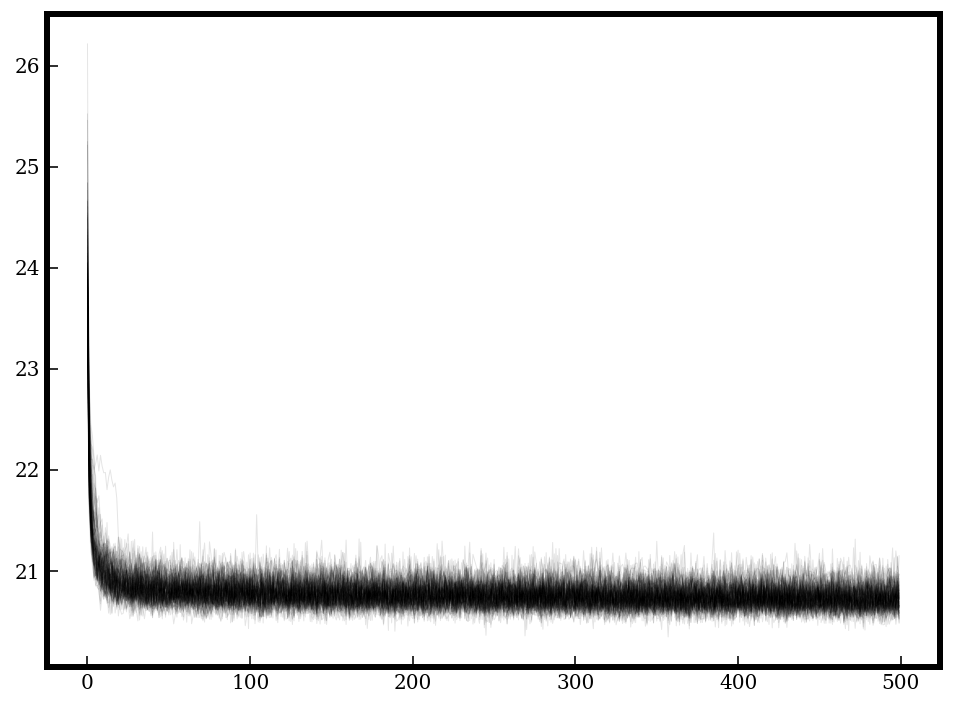

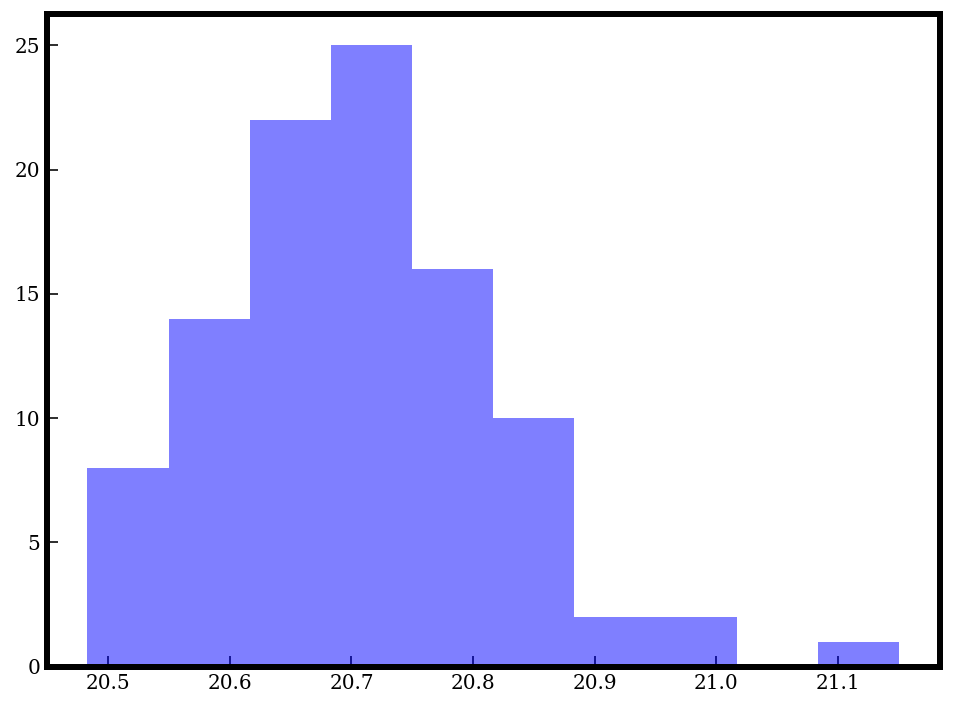

In [149]:
loss_arr = np.zeros((100))

fig1 = plt.figure(figsize=(8,6))

for j in range(0,len(loss_arr)):
    resultsFolder = "./realPlanets_obs"
    loss_arr[j] = getLossFromLogfile("{0}/realKOIs_obsFeatures_seed={1}.log".format(resultsFolder,j))
    losses = getLossSeriesFromLogfile("{0}/realKOIs_obsFeatures_seed={1}.log".format(resultsFolder,j))
    plt.plot(np.arange(500),losses,'k-',lw=0.5,alpha=0.1)
plt.show()
    
fig = plt.figure(figsize=(8,6)) 
plt.hist(loss_arr,color='b',alpha=0.5)    
plt.show()


In [150]:
print(np.min(loss_arr))
print(np.argmin(loss_arr))

20.482965111732
75


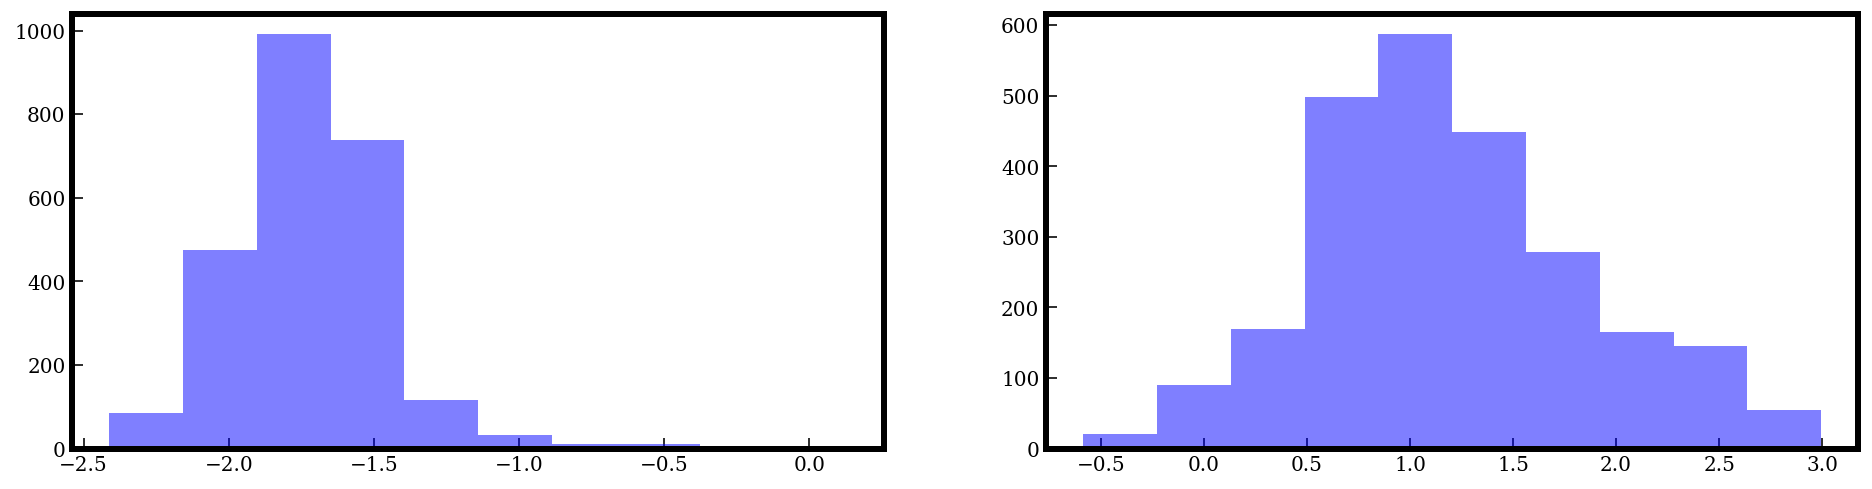

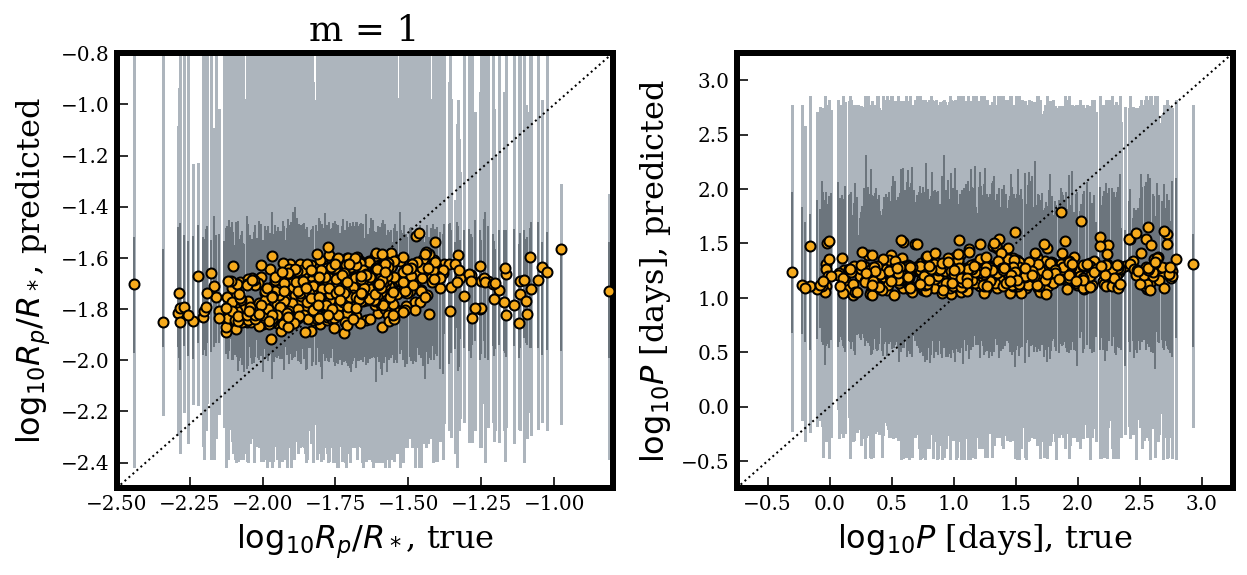

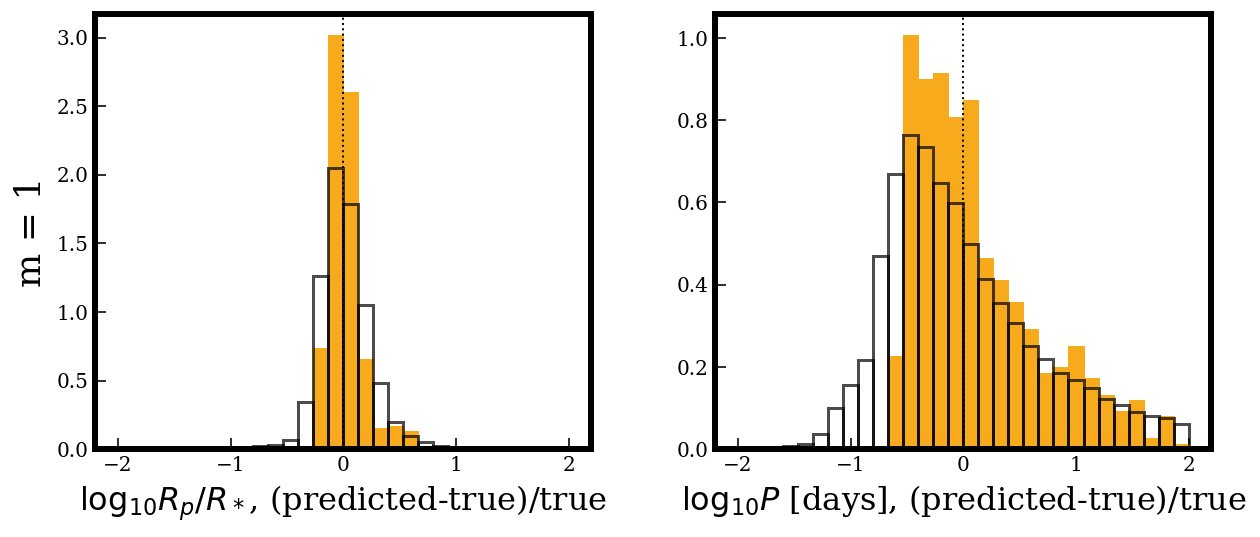

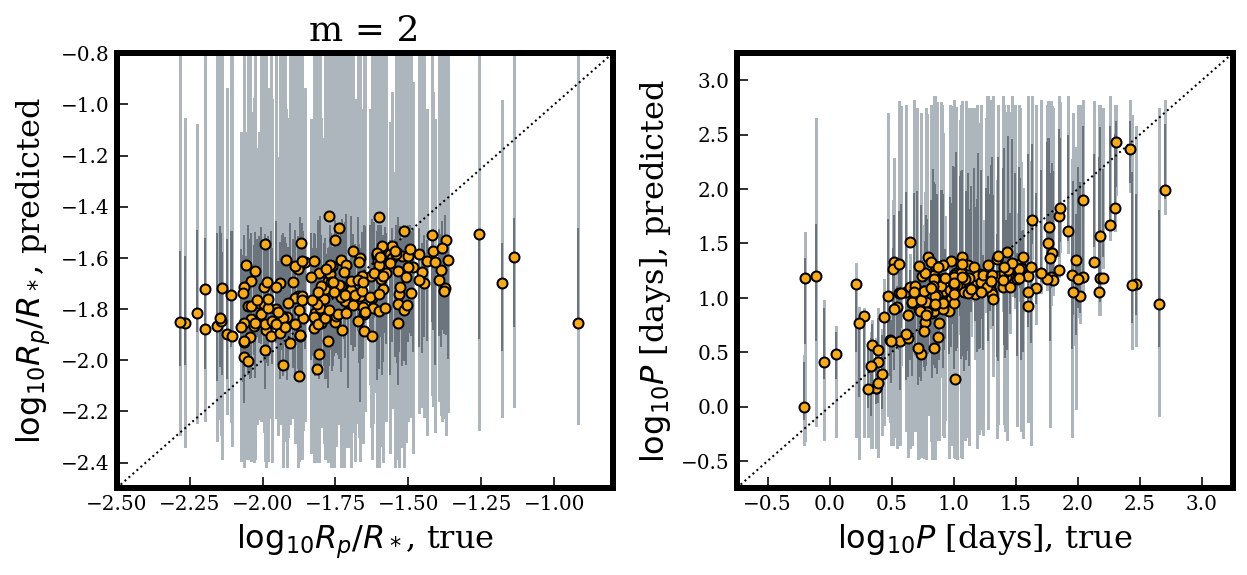

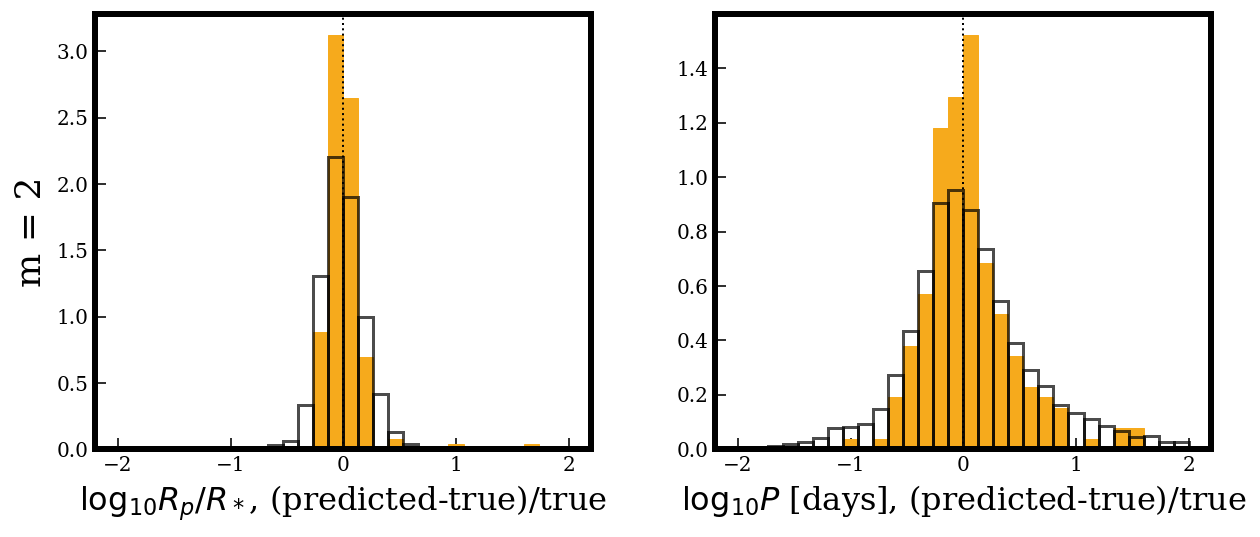

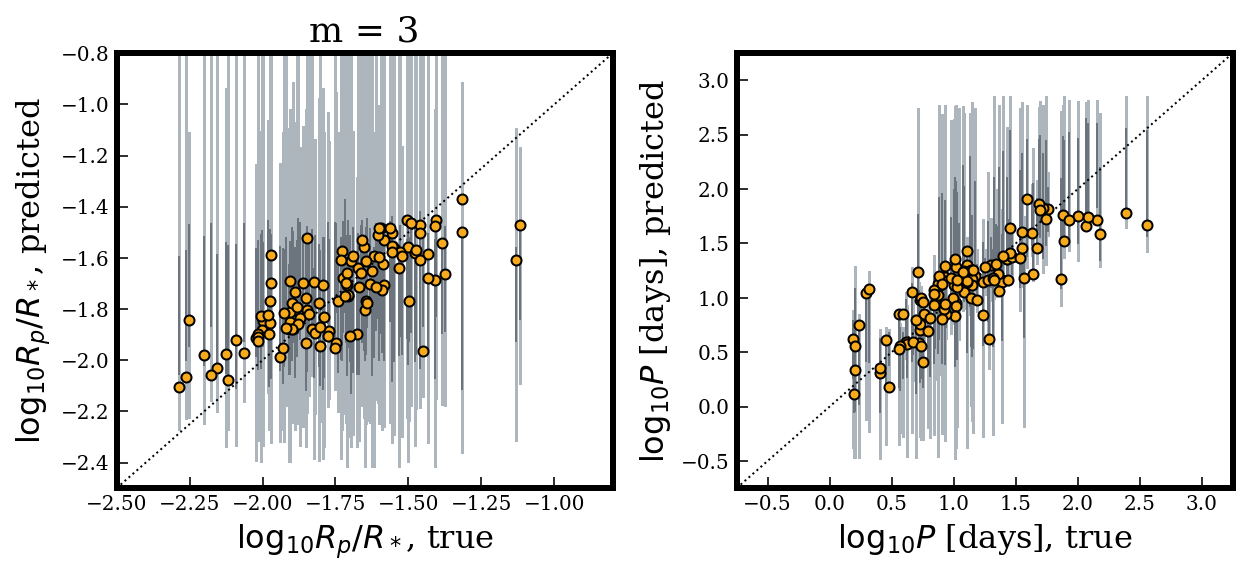

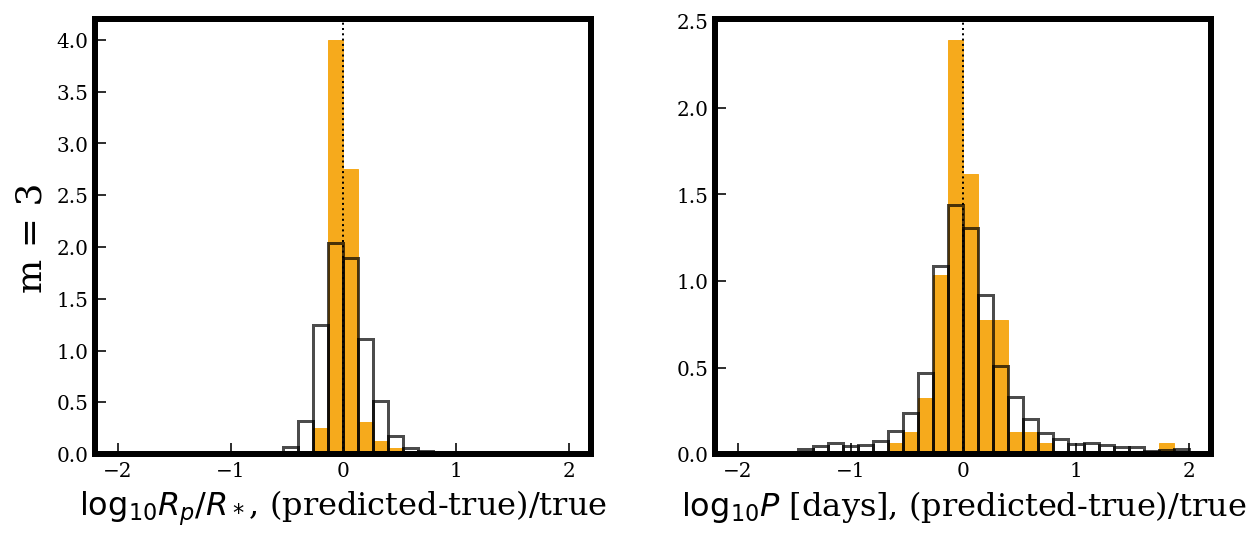

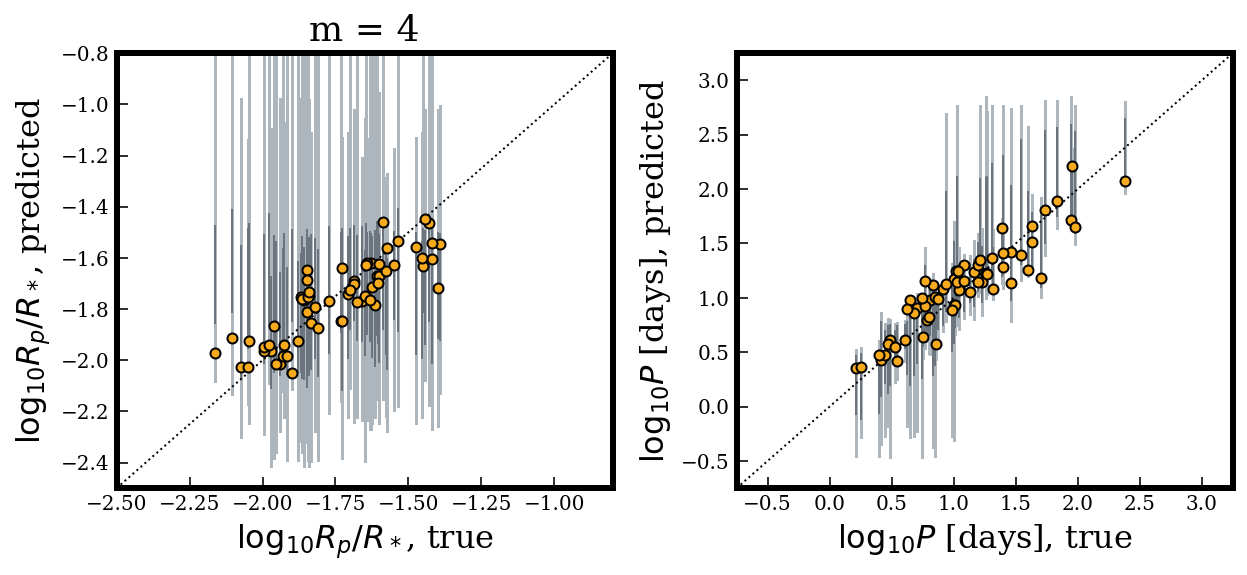

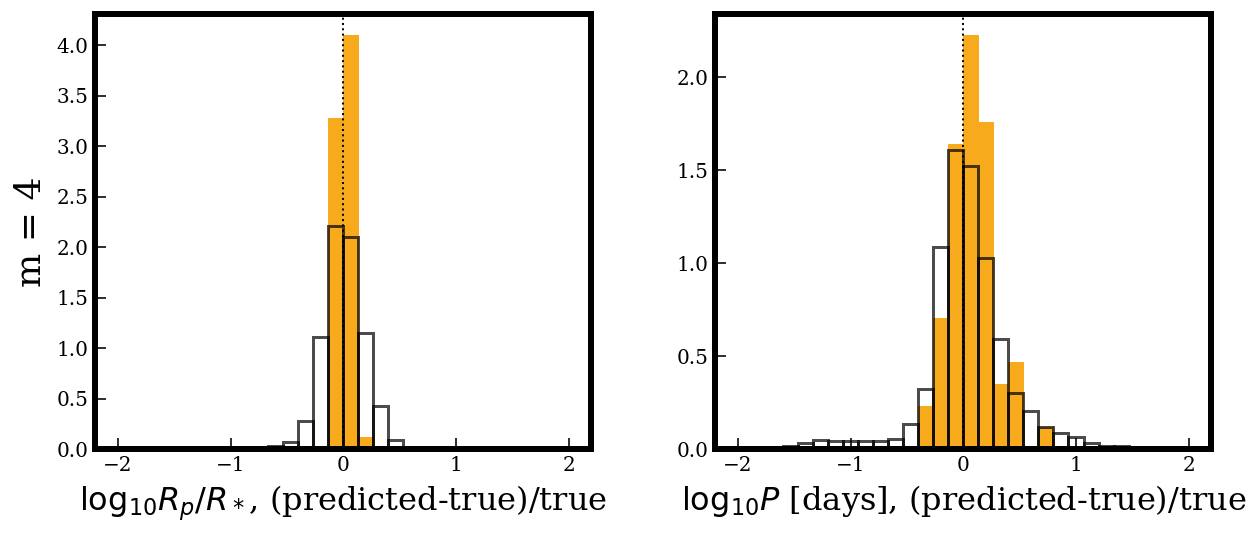

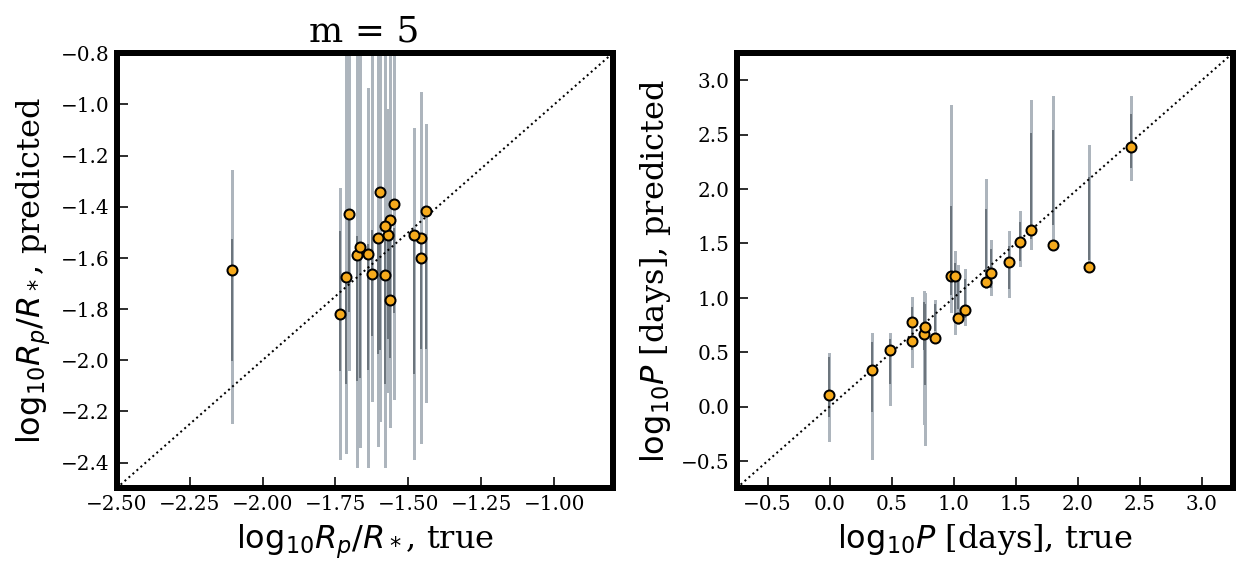

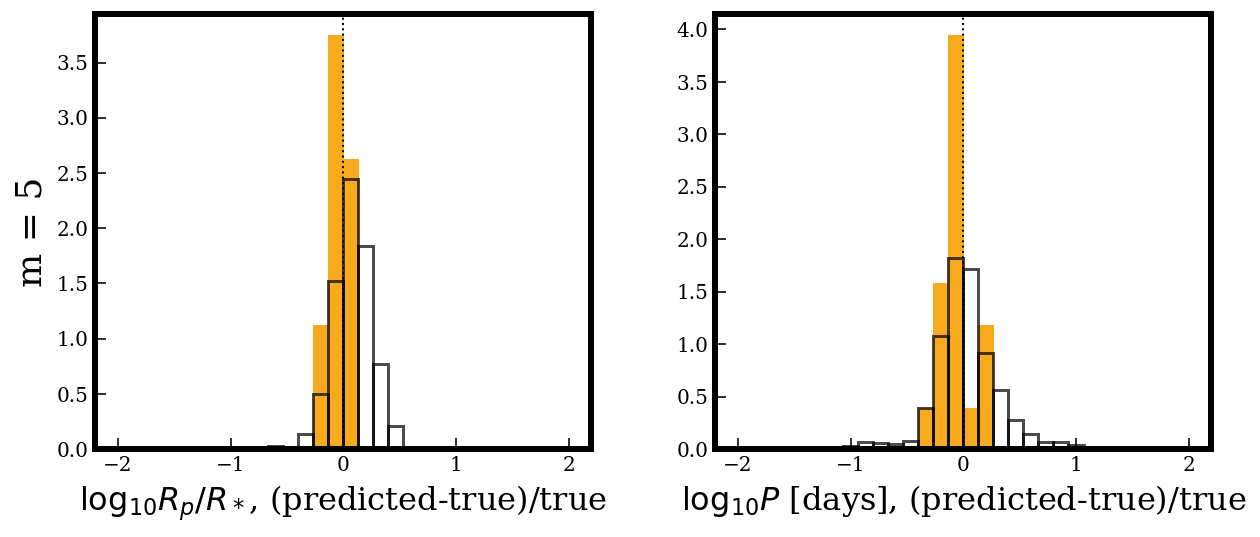

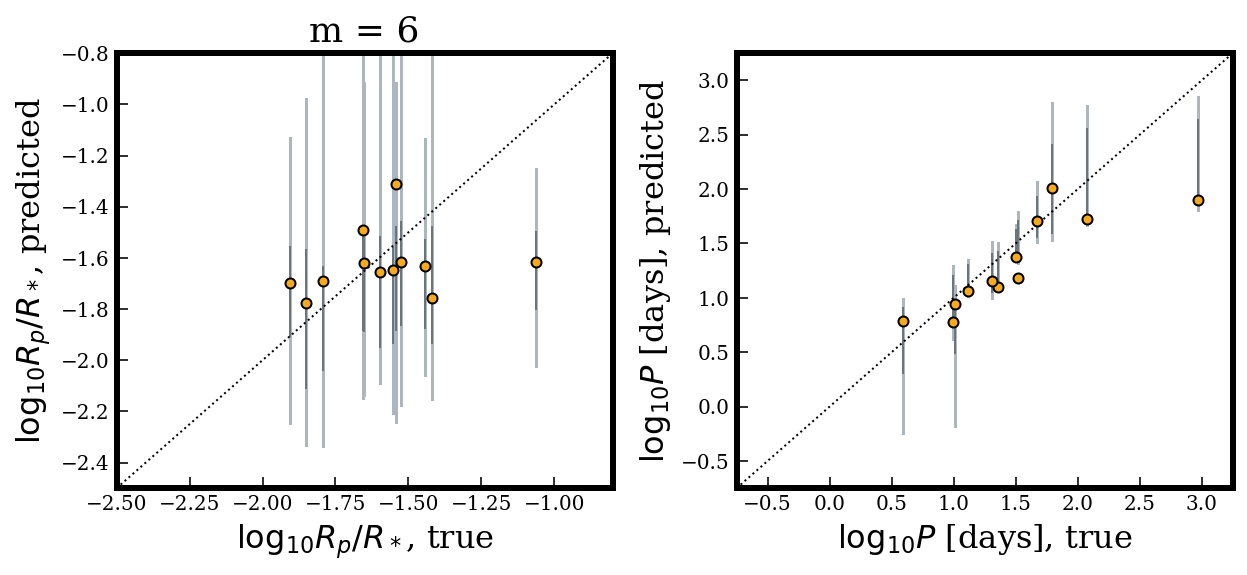

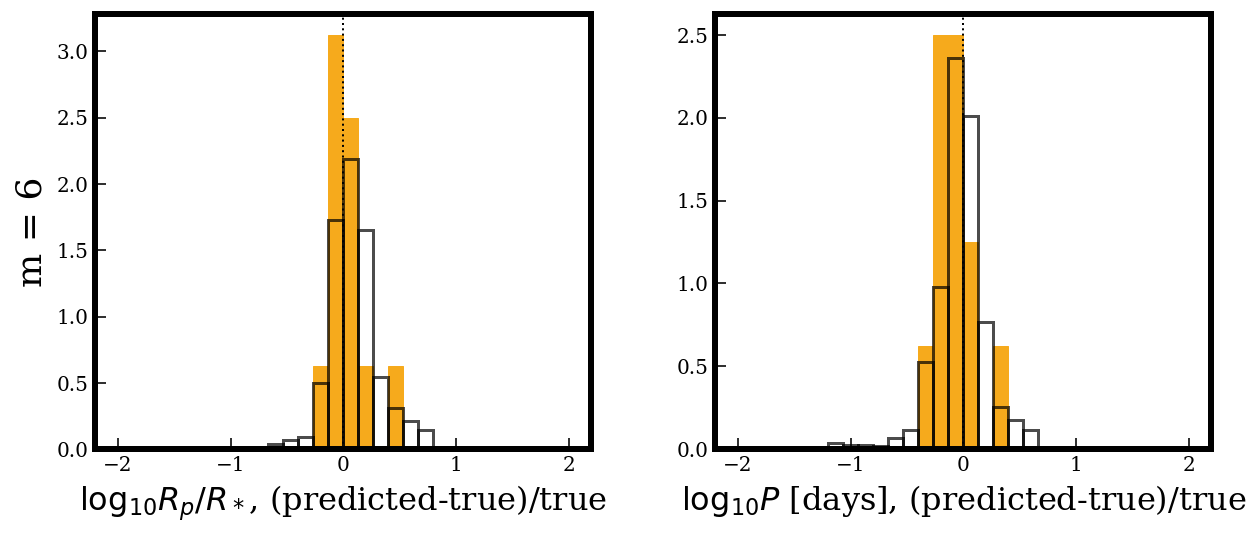

In [151]:
# optimal seed
seed = np.argmin(loss_arr)

predMSE = np.zeros((n_planet_features,6))
randomMSE = np.zeros((n_planet_features,6))


resultsFolder = "./realPlanets_obs"

logfile = "{0}/realKOIs_obsFeatures_seed={1}.log".format(resultsFolder,seed)

# get CV data
with open(CVDataFile, "rb") as picklefile:
    testSystems = pickle.load(picklefile)
    
# constraints colnames:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

CVdata = np.zeros((1,n_planet_features+1))
CVconstraints = np.zeros((1,11))

for i in range(len(testSystems)):
    sys = testSystems[i]
    ID = sys[0]
    for j in range(1,len(sys)):
        row = np.zeros_like(CVdata[0])
        row[:-1] = np.array(sys[j])[0:n_planet_features]
        row[-1] = ID
        CVdata = np.vstack((CVdata,row))
    # organize constraints in the same order
    for j in range(1,len(sys)):
        c_row = np.zeros_like(CVconstraints[0])
        sys_constraints_mask = (constraints[:,0] == ID)
        sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
        for c in sys_constraints_idxs:
            if constraints[c,1] == j-1:
                c_row[:] = constraints[c,3:]
                
        CVconstraints = np.vstack((CVconstraints,c_row))
CVdata = CVdata[1:]
CVconstraints = CVconstraints[1:]

mults = np.zeros_like(CVdata[:,0])
for i in range(len(CVdata)):
    thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
    mults[i] = int(len(CVdata[thisSystemMask]))
    
CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
losses = np.load("{0}/realKOIs_obsFeatures_70percent_losses_{1}.npy".format(resultsFolder,seed))
CVresults = np.load("{0}/realKOIs_obsFeatures_30percent_truths_fromtarget_{1}.npy".format(resultsFolder,seed))
CVresults_fromContext = np.load("{0}/realKOIs_obsFeatures_30percent_predictions_fromcontext_{1}.npy".format(resultsFolder,seed))
CVidxs = np.load("{0}/realKOIs_obsFeatures_30percent_idxs_{1}.npy".format(resultsFolder,seed))

CVdata = CVdata[CVidxs]
CVconstraints = CVconstraints[CVidxs]
    
    
# get training data
trainingIdxs = np.load("{0}/realKOIs_obsFeatures_70percent_idxs_{1}.npy".format(resultsFolder,seed))

with open(trainingDataFile,"rb") as picklefile:
    trainingSystems = pickle.load(picklefile)

trainingData = np.zeros((1,n_planet_features))

for i in range(len(trainingSystems)):
    sys = trainingSystems[i]
    for j in range(1,len(sys)):
        trainingData = np.vstack((trainingData,np.array(sys[j])[0:n_planet_features]))

trainingData = trainingData[1:][trainingIdxs]
    
fig, axes = plt.subplots(1,n_planet_features,figsize=(16,4))
for i in range(n_planet_features):
    axes[i].hist((trainingData[:,i]*sigmas[i])+mus[i],color='b',alpha=0.5)
plt.show()
    
trainingResults = np.load("./{0}/realKOIs_obsFeatures_70percent_truths_fromtarget_{1}.npy".format(resultsFolder,seed))



# naive predictions
randomPredictions = randomStablePlanet(testSetSystems=testSystems, 
                                        testSetResults=CVresults_fromContext,
                                        trainingSetResults=trainingResults, 
                                        trainingSetData=trainingData, 
                                        nSamples=n_samples)
        
randomPredictions = randomPredictions[CVidxs]

# plot training-based predictions
#markers=['.','v','X','1','s','x','^','2','D','o']
markers=['.']
    
# constraints colnames:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr
    
for m in np.sort(np.unique(mults)):
    fig,axes = plt.subplots(1,n_planet_features,figsize = (n_planet_features*5,4))
    '''
    #Rp/R*
    xs = ((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m]
    cs = CVconstraints[CVdata[:,-1] == m]
        
    for cc in range(len(cs)):
        #print(xs[cc])
        #print(cs[cc])
        if cs[cc,0] > 0.:
            axes[0].plot(xs[cc],np.log10(cs[cc,8]),color='b',marker='v',alpha=0.5)
            axes[0].plot(xs[cc]*np.ones((2)),np.log10(np.array((cs[cc,8]-cs[cc,10],cs[cc,8]+cs[cc,9]))),color='b',marker='None',lw=0.5,alpha=0.5)
    
    # period
    xs = ((CVdata[:,1]*sigmas[1])+mus[1])[CVdata[:,-1] == m]
    cs = CVconstraints[CVdata[:,-1] == m]
        
    for cc in range(len(cs)):
        if cs[cc,0] > 0.:
            axes[1].plot(xs[cc]*np.ones((2)),np.log10(cs[cc,2:4]),color='b',marker='None',lw=0.5,alpha=0.5)
    '''        
    for i in range(n_planet_features):    
        axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                     ((CVresults_fromContext[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                     color='#F6AA1C',marker='.',ms=10,mec="k",ls="None",alpha=1,zorder=3)
        
        for p_i in range(len(CVdata[CVdata[:,-1] == m])):
            randomMin = np.min(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i])
            randomMax = np.max(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i])
                
            random16 = np.percentile(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],16)
            random84 = np.percentile(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],84)
                
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                             np.array((randomMin,randomMax)),
                             marker='None',ls='-',lw=1.5,color='#adb5bd',zorder=1)
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                             np.array((random16,random84)),
                             marker='None',ls='-',lw=1,color='#6c757d',zorder=2)
        
        axes[i].set_xlabel("{0}, true".format(labels[i]),fontsize=16)
        axes[i].set_ylabel("{0}, predicted".format(labels[i]),fontsize=16)
        axes[i].set_xlim(scatterlims[i])
        axes[i].set_ylim(scatterlims[i])

        x_ = np.linspace(scatterlims[i][0],scatterlims[i][1],2)
        axes[i].plot(x_,x_,'k:',lw=1)
        #axes[i].legend(loc='best',frameon='False')
    plt.subplots_adjust(wspace=0.5)
    #plt.show()
    axes[0].set_title("m = {0}".format(int(m)),fontsize=18)
    #plt.show()
    plt.subplots_adjust(wspace=0.25)
    plt.savefig("./{0}/realKOIs_obsFeatures_30percent_CV_stablePredictions_{1}_mult={2}.pdf".format(resultsFolder,seed,m),fmt="pdf",bbox_inches="tight")
    #plt.close()
    
    
    
    # histograms of (X_predicted - X_true)/X_true
    fig,axes = plt.subplots(1,n_planet_features,figsize = (n_planet_features*5,4))

    for i in range(n_planet_features):
        phys_truth = ((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]

        phys_pred = ((CVresults_fromContext[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
        frac_err_pred = (phys_pred - phys_truth)/phys_truth
        
        frac_err_random = np.zeros_like(phys_truth)

        for j in range(n_samples):
            phys_random = ((randomPredictions[:,j,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
            frac_err_random_j = (phys_random - phys_truth)/phys_truth
            frac_err_random = np.vstack((frac_err_random,frac_err_random_j))

        frac_err_random = frac_err_random[1:]
        frac_err_random = np.ravel(frac_err_random)
        frac_err_random = frac_err_random
        
        MSE_pred = (1/len(frac_err_pred[np.isfinite(frac_err_pred)]))*np.sum(frac_err_pred[np.isfinite(frac_err_pred)]**2)
        MSE_random = (1/len(frac_err_random[np.isfinite(frac_err_random)]))*np.sum(frac_err_random[np.isfinite(frac_err_random)]**2)

        skew_pred = skew(frac_err_pred)
        skew_random = skew(frac_err_random)
        
        predMSE[int(i),int(m)-1] = MSE_pred
        randomMSE[int(i),int(m)-1] = MSE_random

        
        axes[i].hist(frac_err_pred,density=True,range=lims[i],bins=30,facecolor="#F6AA1C",edgecolor="#F6AA1C",alpha=1,label="network-predicted\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_pred,skew_pred),zorder=1)
        axes[i].hist(frac_err_random,density=True,range=lims[i],bins=30,facecolor="None",edgecolor="k",lw=1.5,alpha=0.7,label="random\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_random,skew_random),zorder=2)    
        
        axes[i].axvline(x=0,color='k',ls=':',lw=1)
        axes[i].set_xlabel("{0}, (predicted-true)/true".format(labels[i]),fontsize=16)

        #axes[i].set_ylabel("count".format(labels[i]),fontsize=16)
        #axes[i].legend(loc="upper right",frameon=False)
    axes[0].set_ylabel("m = {0}".format(int(m)),fontsize=18)
    plt.subplots_adjust(wspace=0.25)
    #plt.show()
    plt.savefig("./{0}/realKOIs_obsFeatures_30percent_CV_stablePredictions_hist_{1}_mult={2}.pdf".format(resultsFolder,seed,m),fmt="pdf",bbox_inches="tight")
    #plt.close()

        

In [152]:
print(np.shape(predMSE))
print(np.shape(np.sum(predMSE,axis=0)))

(2, 6)
(6,)


[0.1709139  0.03005554 0.00890907 0.00400459 0.00830011 0.03386251]


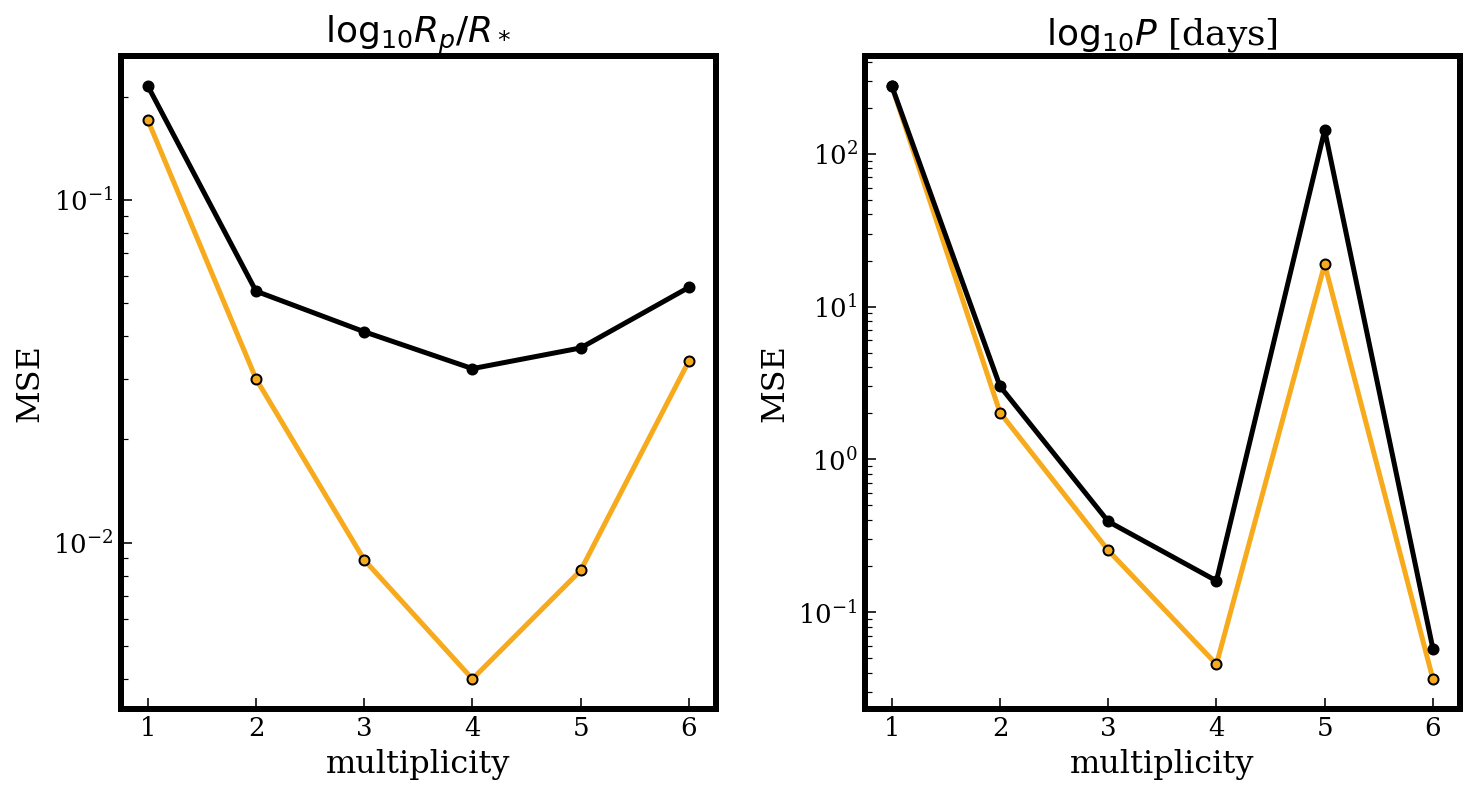

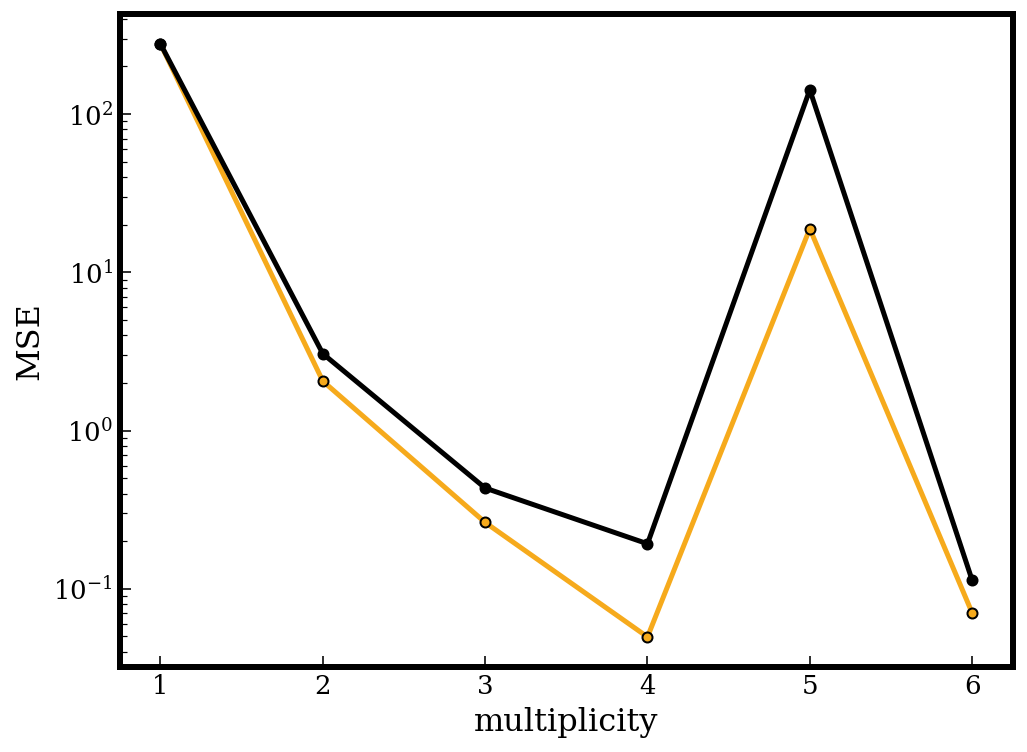

In [153]:

markers=['.','v','X','1','s','x','^','2','D','o']
fig,axes = plt.subplots(1,n_planet_features,figsize=(6*n_planet_features,6))
for j in range(n_planet_features):
    axes[j].plot(np.arange(1,7),predMSE[j],color='#F6AA1C',marker=markers[k],mec='k',ms=10)
    axes[j].plot(np.arange(1,7),randomMSE[j],color='k',marker=markers[k],mec='k',ms=10)
    axes[j].set_xlabel("multiplicity",fontsize=16)
    axes[j].set_ylabel("MSE",fontsize=16)
    axes[j].set_yscale("log")
    axes[j].set_title("{0}".format(labels[j]),fontsize=18)
    for tick in axes[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in axes[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(13)
#plt.show()
plt.subplots_adjust(wspace=0.25)
plt.savefig("./{0}/realKOIs_obsFeatures_30percent_CV_MSEcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')

goodresults = np.arange((6))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,7),np.sum(predMSE,axis=0),color='#F6AA1C',marker='.',mec='k',ms=10,label="network-trained predictions")
ax.plot(np.arange(1,7),np.sum(randomMSE,axis=0),color='k',marker='.',mec='k',ms=10,label="naive predictions")
ax.set_xlabel("multiplicity",fontsize=16)
ax.set_ylabel("MSE",fontsize=16)
#plt.legend(loc="best")
ax.set_yscale("log")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(13)

#plt.show()
plt.savefig("./{0}/realKOIs_obsFeatures_30percent_CV_MSEsumcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')

print(predMSE[0])
